In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
from colorsys import hsv_to_rgb
from random import randint, uniform, seed
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [2]:
%matplotlib inline

In [3]:
tops = pd.read_csv(r"teapot_clean_JRP.csv", index_col=[0]) #read in the top data
tops.rename(columns={'TVDSS':'SS'}, inplace=True)

ssmin = tops.SS.min()
tops.SS = tops.SS - ssmin #standardize the subsea values


In [15]:
tops.dropna(inplace=True)
#tops.drop(['MD', 'GL', 'DELEV', 'DT'], axis=1, inplace=True)
def sample_splitter(dataframe, fraction, randomseed):
    test = dataframe.sample(frac=fraction, random_state=randomseed)
    test_idx = test.index.values
    train =  dataframe.drop(test_idx)
    return train, test

train, test = sample_splitter(tops, 0.01, 86)

print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
R = D_df.values
A = binarize(R) 

print(f'{round(((D_df == 0).astype(int).sum().sum())/((D_df == 0).astype(int).sum().sum()+(D_df != 0).astype(int).sum().sum()),3)*100} percent of the tops are missing')
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    #print("Initiating ")
    lambda_ = lambda_
    n_factors = n_factors
    n, m = A.shape
    n_iterations = n_iterations
    np.random.seed(86)
    Users = 5 * np.random.rand(n, n_factors, )
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MAE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
     #   print(
     #       "Error after solving for User Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
     #   print(
     #       "Error after solving for Item Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        MAE_List.append(get_error(A, Users, Items, R))
     #   print("%sth iteration is complete..." % iter)
    
   # print(MSE_List)
   # fig = plt.figure()
   # ax = fig.add_subplot(111)
   # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
   # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    return Users, Items


Training size is 6604 tops, and test size is 67 tops
88.9 percent of the tops are missing
Starting Iterations
11.337650463502133


In [96]:
def cross_validation(dataframe, random_seed, latent_vectors, n_iters, reg):
    block_1  = dataframe.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    for block in blocks:
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        #print(f'Validating on {block.shape[0]} tops')
        D_df = main_group.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R) 

        
        U, Vt = runALS(R, A, latent_vectors, n_iters, reg)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(validate, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])

        CV_MAE.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

    return CV_MAE

# Grid Search

In [ ]:
%%capture
grid_search = {}
els = []
nsits = []
regulars = []
for L in range(1,11):
    
    for n_it in range(10,450,10):
        for reg in [0.001,0.01,0.1,1,10]:
            grid_search[L,n_it,reg] = np.mean(cross_validation(tops, 86, L, n_it, reg))
            els.append(L)
            nsits.append(n_it)
            regulars.append(reg)
            print(L, n_it, reg)

In [ ]:
L, its, regs = min(grid_search, key=grid_search.get)

In [ ]:
print(L, its, regs)

In [ ]:
errorDF = pd.DataFrame({'L':els, 'iterations':nsits,  'MAE':list(grid_search.values())})
errorDF.to_csv('gridsearch2.csv')

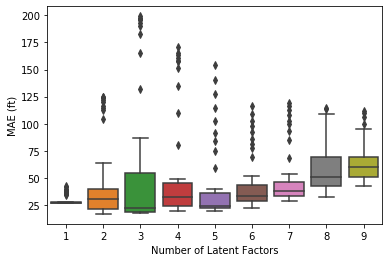

In [194]:
import seaborn as sns
ax0 = sns.boxplot(x="L", y="MAE", data=errorDF)
plt.xlabel('Number of Latent Factors')
plt.ylabel('MAE (ft)')
plt.savefig('latent_factors.svg')

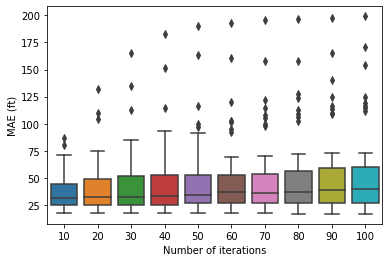

In [195]:
ax1 = sns.boxplot(x="iterations", y="MAE", data=errorDF)
plt.xlabel('Number of iterations')
plt.ylabel('MAE (ft)')
plt.savefig('iterations.svg')

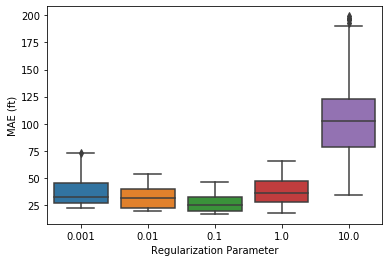

In [196]:
ax1 = sns.boxplot(x="regularization", y="MAE", data=errorDF)
plt.xlabel('Regularization Parameter')
plt.ylabel('MAE (ft)')
plt.savefig('regularization.svg')

In [16]:
cross_validation(tops, 86, 3, 310)

Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[12.446826943855065,
 15.481122355125729,
 17.344292968076857,
 23.350337429415518]

In [11]:
np.mean([12.681816546266408, 15.304179779024471, 20.58050356327627, 15.936947065662677])

16.125861738557457

In [5]:
U, Vt = runALS(R, A, L, its, regs)

recommendations = np.dot(U, Vt) #get the recommendations

recsys = pd.DataFrame(
    data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
) #results

newDF = recsys.T
newDF.reset_index(inplace=True)

flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

new_df.rename(columns={0:'SS_pred'}, inplace=True)

cleanDF = new_df.dropna()

cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])

print(MAE(cleanDF.SS.values+ssmin, cleanDF.SS_pred.values+ssmin))
well_locs = pd.read_csv(r'TeapotDomeWellHeaders.csv')
well_locs.rename(columns={'API Number':'API'}, inplace=True)

locationDF = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

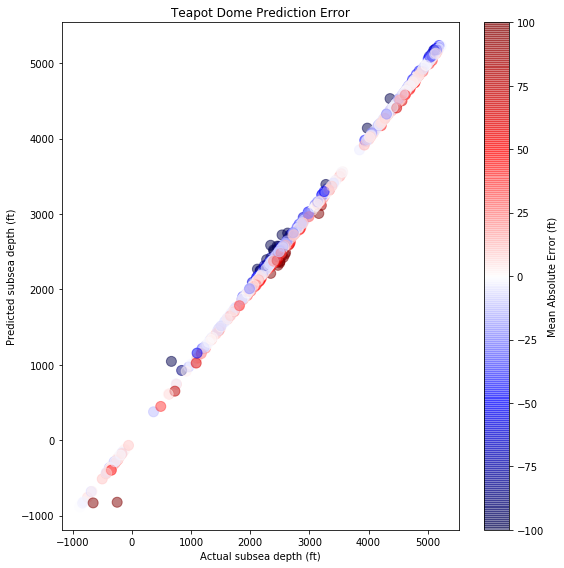

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(cleanDF.SS+ssmin, cleanDF.SS_pred+ssmin, c=cleanDF.signed_error, vmin=-100,vmax=100, 
            cmap='seismic', s=100, alpha=0.5)
plt.plot()
plt.xlabel('Actual subsea depth (ft)')
plt.ylabel('Predicted subsea depth (ft)')
plt.colorbar(label='Mean Absolute Error (ft)')
plt.title('Teapot Dome Prediction Error')
plt.tight_layout()

# Adding stratigraphy

In [ ]:
strat_order = ['SSXS', 'SSXbase','SHNNu', 'SHNNl','SHNNbs','StBR','StFT','StGD','StAM','NBRRws','NBRRsg','CRLL',
                'F1WC',
'F1WCBench1Base', 'F1WCBench2Top', 'F1WCBench2Base', 'F1WCBench3Top',
'F1WCbase','B1','F2WC','F2WCbase',
'F3WC',
'F3WCbase',
'MWRY',
'MDDY',
'THRM',
'DKOT',
'LKOT', # base cret
'MRSN',
'SNDCu',# upper sundance
'CNSP', # base jurassic canyon spring
'CRMT', # Crow mountain, Chugwater Group/FM
'ALCV', # Alcova ls, chugwater
'RDPK', # base Triassic chugwater
'ERVY', # goose egg member
'FRLL', # goose egg
'GLND', # goose egg
'MNKT', # goose egg
'OPCH', # goose egg Base Permian
'A Sand', # Tensleep 
'B Dolo',
'B Sand',
'C1 Dolo',
'C1 Sand',
'C2 Dolo',
'C2 Sand',
'C3 Dolo',
'C3 Sand',
'C4 Dolo',
'C4 Sand',
'D Dolo',
'D Sand',
'E Dolo',
'AMSD', # base Pennsylvanian
'MDSN', # base mississippian
'PC'
]

color_list = []
for i in range(len(strat_order)):
    if i <=29: #cretaceous
        h = uniform(83/360, 158/360) # Select random green'ish hue from hue wheel
        s = uniform(0.8, 1)
        v = uniform(0.2, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
    elif 29<i<=32: #Jurassic
        h = uniform(138/360, 200/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 32<i<=35: #triassic
        h = uniform(156/360, 180/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 35<i<= 40: #permian
        h = uniform(190/360, 200/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 40<i<= 55: #Pennsylvanian
        h = uniform(210/360, 230/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 55<i<= 56: #missippian
        h = uniform(240/360, 260/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    else: #PC
        h = uniform(300/360, 320/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

colors_to_plot = dict(zip(strat_order, color_list))

In [ ]:
#pd.DataFrame(colors_to_plot).to_csv('color_palette.csv', index=False)
colors_to_plot =  pd.read_csv('color_palette.csv').to_dict(orient='list')

In [ ]:
mae_errors = []
n_holdout = []
formed = []
colored = []
stdev = []
n_picks = []
rms_errors = []
for formation in strat_order:
    form = locationDF[locationDF['Formation'] == formation]
    try:
        print(str(formation)+' mean absolute error is '+str(round(np.sqrt(MAE(form.SS.values-ssmin, form.SS_pred.values-ssmin)),1))
          +' n holdout='+str(form.shape[0])+' standard deviation is '+str(np.round(np.std(form.signed_error),2))
              +' n picks='+str(tops[tops.Formation == formation].shape[0])
              +' max is '+str(np.round(form.signed_error.max(),2))
              +' min is '+str(np.round(form.signed_error.min(),2)))
        mae_errors.append(round(MAE(form.SS.values-ssmin, form.SS_pred.values-ssmin),1))
        formed.append(formation)
        colored.append(colors_to_plot[formation])
        stdev.append(np.std(form.signed_error))
        n_holdout.append(form.shape[0])
        n_picks.append(tops[tops.Formation == formation].shape[0])
        rms_errors.append(np.sqrt(MSE(form.SS.values-ssmin, form.SS_pred.values-ssmin)))
    except:
        print(str(formation)+' has no holdout samples'+' n picks='+str(tops[tops.Formation == formation].shape[0]))
        mae_errors.append(np.nan)
        formed.append(formation)
        colored.append(colors_to_plot[formation])
        stdev.append(np.std(form.signed_error))
        n_picks.append(form.shape[0])
        n_holdout.append(tops[tops.Formation == formation].shape[0])
        rms_errors.append(np.nan)

flat_preds.rename(columns={0:'SS_pred'}, inplace=True)
flat_preds['SS_pred'] = flat_preds['SS_pred'] + ssmin

In [ ]:
table_1 = pd.DataFrame({'Formation':formed, 'n_picks': n_picks, 'n_holdout':n_holdout, 'MAE':mae_errors,
             'RMSE':rms_errors, 'Std':stdev})
table_1.to_csv('Table1.csv')

In [105]:
flat_preds[flat_preds.API == 490251103200].to_csv('upper_well.csv') # upper well 
flat_preds[flat_preds.API == 490252319500].to_csv('middle_well.csv') # middle well
flat_preds[flat_preds.API == 490250633800].to_csv('lower_well.csv') # lower well

In [107]:
summary = pd.DataFrame({'MAE': mae_errors, 'n_picks': n_picks, 'formation': formed, 'stdev': stdev, 'n_holdout':n_holdout })
summary.to_csv('error_teapot.csv')

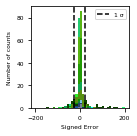

In [108]:
fig, ax = plt.subplots(1,1, figsize=(2,2))

for formation in strat_order:
    form = locationDF[locationDF['Formation'] == formation]
    plt.hist(form.signed_error, range=(-200,200), bins=40, stacked=True, color=colors_to_plot[formation])
plt.vlines(np.std(locationDF.signed_error), 0,90, linestyle='dashed') #95% of the picks are within these
plt.vlines(-1*np.std(locationDF.signed_error), 0,90, linestyle='dashed', label='1 σ')
plt.xlabel('Signed Error', fontsize=6)
plt.ylabel('Number of counts', fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.ylim(0,90)
plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig('histogram.svg')

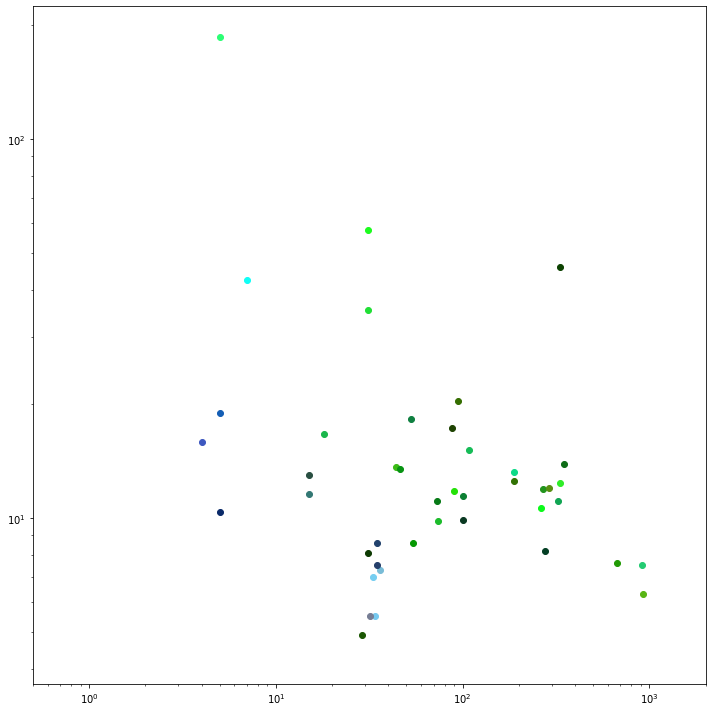

In [109]:
nums = dict(zip(formed, n_picks))
errers = dict(zip(formed, mae_errors))
val = dict(zip(formed, n_holdout))
fig, ax = plt.subplots(1,1, figsize=(10,10))

for formation in strat_order:
        plt.scatter(nums[formation], errers[formation], color=colors_to_plot[formation])
plt.semilogx()
plt.semilogy()
#plt.xlabel('Number of top picks of each formation', fontsize=6)
#plt.ylabel('MAE (ft)', fontsize=6)
#plt.xticks(fontsize=6)
#plt.yticks(fontsize=6)
plt.xlim(0.5, 2000)
plt.ylim()
plt.tight_layout()

In [110]:
locationDF_full = tops.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
predictions = flat_preds.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

signed = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

This is test size error calculation

In [117]:
%%capture
big_de_error = []
for ran in range(100):
    de_error = []
    for i in np.arange(0.99, 0, -0.1):
        train, test = sample_splitter(tops, i, ran)
        print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')
        D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        from sklearn.preprocessing import binarize
        A = binarize(R) 
        U, Vt = runALS(R, A, 3, 20, 0.1)
        recommendations = np.dot(U, Vt) #get the recommendations
        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results
        newDF = recsys.T
        newDF.reset_index(inplace=True)
        #test = newDF[["FORT UNION", "API"]]
        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()
        new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])
        new_df.rename(columns={0:'SS_pred'}, inplace=True)
        cleanDF = new_df.dropna()
        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])
        de_error.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

        locationDF = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
    big_de_error.append(de_error)
    
'''
        for formation in strat_order:
            form = locationDF[locationDF['Formation'] == formation]
            plt.hist(form.signed_error, range=(-200,200), bins=40, stacked=True, color=colors_to_plot[formation])
        plt.vlines(locationDF.quantile(0.05).signed_error, 0,80, linestyle='dashed') #95% of the picks are within these
        plt.vlines(locationDF.quantile(0.95).signed_error, 0,80, linestyle='dashed', label='95% Quantile')
        plt.xlabel('Signed Error')
        plt.ylabel('Number of counts')
        plt.legend()
        plt.show()
        plt.clf()
'''

Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations
Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations
Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations
Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 67 tops, and test size is 6605 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 734 tops, and test size is 5938 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 1401 tops, and test size is 5271 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2068 tops, and test size is 4604 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 2736 tops, and test size is 3936 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3403 tops, and test size is 3269 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4070 tops, and test size is 2602 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4737 tops, and test size is 1935 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5404 tops, and test size is 1268 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 6072 tops, and test size is 600 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


"\n        for formation in strat_order:\n            form = locationDF[locationDF['Formation'] == formation]\n            plt.hist(form.signed_error, range=(-200,200), bins=40, stacked=True, color=colors_to_plot[formation])\n        plt.vlines(locationDF.quantile(0.05).signed_error, 0,80, linestyle='dashed') #95% of the picks are within these\n        plt.vlines(locationDF.quantile(0.95).signed_error, 0,80, linestyle='dashed', label='95% Quantile')\n        plt.xlabel('Signed Error')\n        plt.ylabel('Number of counts')\n        plt.legend()\n        plt.show()\n        plt.clf()\n"

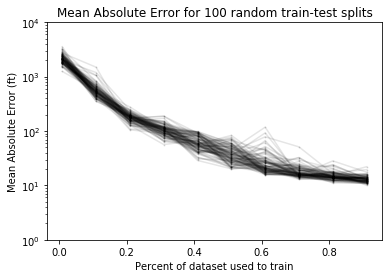

In [142]:
for i in range(len(big_de_error)):
    
    plt.plot(np.arange(0.01,1,0.1), big_de_error[i], c='k', marker='o', markersize=1, alpha=0.1)
    plt.ylim(1,10000)
    plt.semilogy()
    plt.ylabel('Mean Absolute Error (ft)')
    plt.xlabel('Percent of dataset used to train')
    plt.title('Mean Absolute Error for 100 random train-test splits')
    
    plt.savefig(r'E:\UT Austin\Manuscripts\RecSys\Figures\working\testvstrain.svg')

### Now let's hold out one well and slowly add in tops for it

In [ ]:
ssmin = tops.SS.min()
tops.SS = tops.SS - ssmin #standardize the subsea values
from sklearn.metrics import mean_absolute_error as MAE

tops.dropna(inplace=True)

def well_sample_splitter(dataframe, master_dataframe, number_of_tops, randomseed):
    test = dataframe.sample(n=number_of_tops, random_state=randomseed)
    test_idx = test.index.values
    train =  master_dataframe.drop(test_idx)
    return train, test

well_errors = []
for well in range(100):
    moving_well = tops[tops.API == tops.API.unique()[well]]
    errors = []
    for i in range(1, moving_well.shape[0], 1):

        train, test = well_sample_splitter(moving_well, tops, i, 86)

        #print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

        D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        from sklearn.preprocessing import binarize
        A = binarize(R) 
        U, Vt = runALS(R, A, 3, 20, 0.1)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])

        errors.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))
    print(f'Done with {well+1} wells')
    well_errors.append(errors)

# Error by well

In [47]:
aypi = []
well_mae = []
well_rmse = []
east = []
north = []
for well in tops.API.unique():
    thing = locationDF[locationDF.API == well]
    east.append(thing.Easting.values[0])
    north.append(thing.Northing.values[0])
    aypi.append(well)
    well_mae.append(thing.signed_error.abs().mean())
    try: 
        well_rmse.append(np.sqrt(MSE(thing.SS, thing.SS_pred)))

    except:
         well_rmse.append(np.nan)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [113]:
by_wellDF = pd.DataFrame({'API':aypi, 'Well_MAE':well_mae, 'well_rmse':well_rmse, 'Easting':east, 'Northing':north})
by_wellDF.to_csv('error_map.csv')

In [114]:
cv_wells = []
def cross_validation_wells(dataframe, random_seed, latent_vectors, n_iters):
    block_1  = dataframe.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    f = 0
    print(sorted(block_1) == sorted(block_4))
    for block in blocks:
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f'Validating on {block.shape[0]} tops')
        D_df = main_group.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R) 

        
        U, Vt = runALS(R, A, latent_vectors, n_iters, 0.1)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(validate, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])
        well_locs = pd.read_csv(r'TeapotDomeWellHeaders.csv')
        well_locs.rename(columns={'API Number':'API'}, inplace=True)

        locationDF = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
        aypi = []
        well_mae = []
        well_rmse = []
        east = []
        north = []
        fold = []
        
        print(f'foldno is {f}')
        for well in locationDF.API.unique():
            aypi.append(well)
            well_mae.append(locationDF[locationDF.API == well].signed_error.abs().mean())
            well_rmse.append(np.sqrt(MSE(locationDF[locationDF.API == well].SS, locationDF[locationDF.API == well].SS_pred)))
            east.append(locationDF[locationDF.API == well].Easting.values[0])
            north.append(locationDF[locationDF.API == well].Northing.values[0])
            fold.append(f)
        by_wellDF = pd.DataFrame({'API':aypi, 'Well_MAE':well_mae, 'well_rmse':well_rmse, 'Easting':east, 'Northing':north,
                                 'foldno':fold})
        cv_wells.append(by_wellDF)
        f+=1
        #CV_MAE.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

    return cv_wells

In [115]:
masterDF = pd.concat(cross_validation_wells(tops, 86, 3, 5))

False
Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 0
Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 1
Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 2
Validating on 1667 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 3


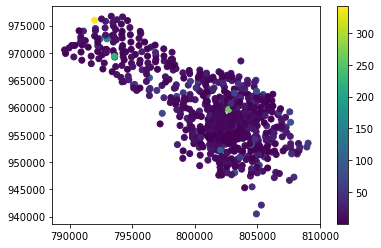

In [127]:
plt.scatter(masterDF[masterDF.foldno == 3].Easting, masterDF[masterDF.foldno == 3].Northing, 
            c=masterDF[masterDF.foldno == 3].Well_MAE)
plt.colorbar()

In [126]:
masterDF[masterDF.foldno ==2].sort_values('Well_MAE')

,API,Well_MAE,well_rmse,Easting,Northing,foldno
34,490251067200,0.018053,0.018053,800280.8,960373.5,2
324,490251120700,0.159021,0.159021,801148.6,954328.8,2
638,490250637500,0.245274,0.245274,807675.4,956010.4,2
654,490250949200,0.362858,0.362858,791006.9,971447.8,2
500,490250639400,0.413408,0.413408,804978.1,956624.0,2
...,...,...,...,...,...,...
397,490251060000,275.192892,333.879870,801678.9,950672.7,2
404,490251076400,302.936442,391.194852,799037.2,950662.6,2
132,490250644400,322.496462,322.496462,807581.3,959197.4,2
122,490251033100,330.257854,477.587321,799063.7,952035.6,2


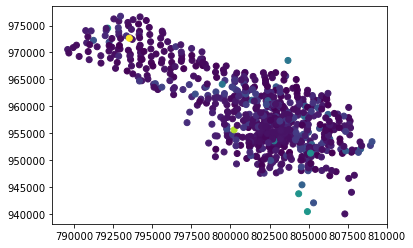

In [117]:
plt.scatter(masterDF[masterDF.foldno == 1].Easting, masterDF[masterDF.foldno == 1].Northing, 
            c=masterDF[masterDF.foldno == 1].Well_MAE)

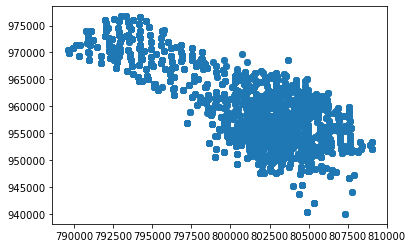

In [98]:
well_locs = pd.read_csv(r'TeapotDomeWellHeaders.csv')
well_locs.rename(columns={'API Number':'API'}, inplace=True)

what = tops.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
plt.scatter(what.Easting, what.Northing)

### How about Pyvista?

In [114]:
import pyvista as pv
import panel
from itkwidgets import view
panel.extension("vtk")
pv.set_plot_theme("document")

In [115]:
gl = tops
surface = gl.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
cloud = pv.PolyData(np.array(list(zip(surface.Easting, surface.Northing, surface.GL))))
surf = cloud.delaunay_2d()

In [116]:
plotter = pv.Plotter(notebook=False)
for formation in strat_order:
    subpreds = predictions[predictions['Formation'] == formation]
    points = np.array(list(zip(subpreds.Easting, subpreds.Northing, subpreds['SS_pred'])))
    if points.shape[0] > 0:
        pc = pv.PolyData(points)
    #data = tops_predicted[i][:,-1]
    #pc['elevation'] = data
    plotter.add_points(pc, color=colors_to_plot[formation])#color=[r,g,b])
plotter.add_mesh(surf)
plotter.set_scale(1,1,2, 0) #V.E.
plotter.show()

[(757307.6267964147, 968437.0174101141, 4291.038160416518),
 (790331.6244495068, 962575.1446693249, 2639.919502313689),
 (0.09975417451186847, 0.0014532899344701124, 0.9950110515043649)]